In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from nltk.stem import PorterStemmer,WordNetLemmatizer
import matplotlib.pyplot as plt
import nltk 
import string
import re
from sklearn import metrics
from bs4 import BeautifulSoup
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
pd.set_option('display.max_colwidth', 100) 

In [2]:
#Loading the data
tweets = pd.read_csv('covid19_tweets.csv') # dataset on covid

In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


In [1]:
tweets.describe()

NameError: name 'tweets' is not defined

In [4]:
#Let's find out about the missing values in the dataset by executing the code below:
tweets.isna().sum()

user_name               0
user_location       36771
user_description    10286
user_created            0
user_followers          0
user_friends            0
user_favourites         0
user_verified           0
date                    0
text                    0
hashtags            51334
source                 77
is_retweet              0
dtype: int64

In [5]:
tweets = tweets.drop(columns=['user_name','user_location','user_description','user_created','user_followers','user_friends','user_favourites','user_verified','date','hashtags','source','is_retweet']) # dropping dat column since the date is not relevant for classification
tweets.head() # first 5 rows data of dataset file

,text
0,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were ..."
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay thei...
2,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim ...
3,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that wer...
4,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @...


# CLEANING THE TWEETS

In [6]:
#combine a regular expression pattern into pattern objects
space_replace = re.compile('[/(){}\[\]\|@,;]') 
bad_symbols = re.compile('[^0-9a-z #+_]')
#stopwords = nltk.corpus.stopwords.words('english')
stopwords = ['rt', 'RT', 'brt']
#stopwords.extend(extensions)
urls = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+' 'rt')
usernames = re.compile("@[A-Za-z0-9_]+")
def text_cleaning(text):
    text = usernames.sub(' ', text)
    text = BeautifulSoup(text, "lxml").text #removing any html decoding
    text = text.lower() #removing capitalization
    text = space_replace.sub(' ', text)#replacing symbols with a space
    text = bad_symbols.sub('', text) #deleting symbols from the text
    text = ' '.join(word for word in text.split() if word not in stopwords) #removing stopwords
    text = urls.sub('', text)#removing urls
    return text
tweets['cleaned_text'] = tweets['text'].apply(text_cleaning)
tweets.head()

,text,cleaned_text
0,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were ...",if i smelled the scent of hand sanitizers today on someone in the past i would think they were s...
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay thei...,hey and wouldnt it have made more sense to have the players pay their respects to the a https tc...
2,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim ...,trump never once claimed #covid19 was a hoax we all claim that this effort to https tco jkk8vhwhb3
3,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that wer...,the one gift #covid19 has give me is an appreciation for the simple things that were always arou...
4,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @...,25 july media bulletin on novel #coronavirusupdates #covid19 https tco mn0eecsjhh


In [7]:
#tokenizing the words
def word_tokenizer(text):
    word_tokens = re.split('\W+', text)
    return word_tokens

'''to process text, we need to split it into smaller chunks. 
Here, I’ve split sentences into words using WordPunctTokenizer from the nltk library.'''
tweets['tokenized_text'] = tweets['cleaned_text'].apply(lambda x: word_tokenizer(x.lower())) #  make list of relevant wordsin lower case( without stopwords)
tweets.head()


,text,cleaned_text,tokenized_text
0,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were ...",if i smelled the scent of hand sanitizers today on someone in the past i would think they were s...,"[if, i, smelled, the, scent, of, hand, sanitizers, today, on, someone, in, the, past, i, would, ..."
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay thei...,hey and wouldnt it have made more sense to have the players pay their respects to the a https tc...,"[hey, and, wouldnt, it, have, made, more, sense, to, have, the, players, pay, their, respects, t..."
2,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim ...,trump never once claimed #covid19 was a hoax we all claim that this effort to https tco jkk8vhwhb3,"[trump, never, once, claimed, covid19, was, a, hoax, we, all, claim, that, this, effort, to, htt..."
3,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that wer...,the one gift #covid19 has give me is an appreciation for the simple things that were always arou...,"[the, one, gift, covid19, has, give, me, is, an, appreciation, for, the, simple, things, that, w..."
4,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @...,25 july media bulletin on novel #coronavirusupdates #covid19 https tco mn0eecsjhh,"[25, july, media, bulletin, on, novel, coronavirusupdates, covid19, https, tco, mn0eecsjhh]"


In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shara\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [9]:
#removing stopwords
'''removed stopwords since they add noise without bringing any information value in modeling. 
I’ve downloaded a list of English stopwords from the nltk package and deleted them from the text corpus.'''
stopwords = nltk.corpus.stopwords.words('english') 

def stopword_remover(text):
    cleaned_text = [word for word in text if word not in stopwords]
    return cleaned_text

tweets['no_stopwords'] =tweets['tokenized_text'].apply(lambda x: stopword_remover(x))
tweets.head()

,text,cleaned_text,tokenized_text,no_stopwords
0,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were ...",if i smelled the scent of hand sanitizers today on someone in the past i would think they were s...,"[if, i, smelled, the, scent, of, hand, sanitizers, today, on, someone, in, the, past, i, would, ...","[smelled, scent, hand, sanitizers, today, someone, past, would, think, intoxicated, https, tco, ..."
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay thei...,hey and wouldnt it have made more sense to have the players pay their respects to the a https tc...,"[hey, and, wouldnt, it, have, made, more, sense, to, have, the, players, pay, their, respects, t...","[hey, wouldnt, made, sense, players, pay, respects, https, tco, 1qvw0zgypu]"
2,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim ...,trump never once claimed #covid19 was a hoax we all claim that this effort to https tco jkk8vhwhb3,"[trump, never, once, claimed, covid19, was, a, hoax, we, all, claim, that, this, effort, to, htt...","[trump, never, claimed, covid19, hoax, claim, effort, https, tco, jkk8vhwhb3]"
3,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that wer...,the one gift #covid19 has give me is an appreciation for the simple things that were always arou...,"[the, one, gift, covid19, has, give, me, is, an, appreciation, for, the, simple, things, that, w...","[one, gift, covid19, give, appreciation, simple, things, always, around, https, tco, z0poalfxcw]"
4,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @...,25 july media bulletin on novel #coronavirusupdates #covid19 https tco mn0eecsjhh,"[25, july, media, bulletin, on, novel, coronavirusupdates, covid19, https, tco, mn0eecsjhh]","[25, july, media, bulletin, novel, coronavirusupdates, covid19, https, tco, mn0eecsjhh]"


In [10]:
#Stemming words
porter_stemmer = PorterStemmer()
def word_stemer(text):
    stemmed_text = [porter_stemmer.stem(word) for word in text]
    return stemmed_text
tweets['stemmed_text'] = tweets['no_stopwords'].apply(lambda x: word_stemer(x))
tweets.head()

,text,cleaned_text,tokenized_text,no_stopwords,stemmed_text
0,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were ...",if i smelled the scent of hand sanitizers today on someone in the past i would think they were s...,"[if, i, smelled, the, scent, of, hand, sanitizers, today, on, someone, in, the, past, i, would, ...","[smelled, scent, hand, sanitizers, today, someone, past, would, think, intoxicated, https, tco, ...","[smell, scent, hand, sanit, today, someon, past, would, think, intox, http, tco, qzvybrogb0]"
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay thei...,hey and wouldnt it have made more sense to have the players pay their respects to the a https tc...,"[hey, and, wouldnt, it, have, made, more, sense, to, have, the, players, pay, their, respects, t...","[hey, wouldnt, made, sense, players, pay, respects, https, tco, 1qvw0zgypu]","[hey, wouldnt, made, sens, player, pay, respect, http, tco, 1qvw0zgypu]"
2,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim ...,trump never once claimed #covid19 was a hoax we all claim that this effort to https tco jkk8vhwhb3,"[trump, never, once, claimed, covid19, was, a, hoax, we, all, claim, that, this, effort, to, htt...","[trump, never, claimed, covid19, hoax, claim, effort, https, tco, jkk8vhwhb3]","[trump, never, claim, covid19, hoax, claim, effort, http, tco, jkk8vhwhb3]"
3,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that wer...,the one gift #covid19 has give me is an appreciation for the simple things that were always arou...,"[the, one, gift, covid19, has, give, me, is, an, appreciation, for, the, simple, things, that, w...","[one, gift, covid19, give, appreciation, simple, things, always, around, https, tco, z0poalfxcw]","[one, gift, covid19, give, appreci, simpl, thing, alway, around, http, tco, z0poalfxcw]"
4,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @...,25 july media bulletin on novel #coronavirusupdates #covid19 https tco mn0eecsjhh,"[25, july, media, bulletin, on, novel, coronavirusupdates, covid19, https, tco, mn0eecsjhh]","[25, july, media, bulletin, novel, coronavirusupdates, covid19, https, tco, mn0eecsjhh]","[25, juli, media, bulletin, novel, coronavirusupd, covid19, http, tco, mn0eecsjhh]"


In [11]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
#Word Lemmatization
word_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    text = [word_lemmatizer.lemmatize(word) for word in text]
    return text
tweets['Lemmatized_text'] = tweets['no_stopwords'].apply(lambda x: lemmatizer(x))
tweets.head()

,text,cleaned_text,tokenized_text,no_stopwords,stemmed_text,Lemmatized_text
0,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were ...",if i smelled the scent of hand sanitizers today on someone in the past i would think they were s...,"[if, i, smelled, the, scent, of, hand, sanitizers, today, on, someone, in, the, past, i, would, ...","[smelled, scent, hand, sanitizers, today, someone, past, would, think, intoxicated, https, tco, ...","[smell, scent, hand, sanit, today, someon, past, would, think, intox, http, tco, qzvybrogb0]","[smelled, scent, hand, sanitizers, today, someone, past, would, think, intoxicated, http, tco, q..."
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay thei...,hey and wouldnt it have made more sense to have the players pay their respects to the a https tc...,"[hey, and, wouldnt, it, have, made, more, sense, to, have, the, players, pay, their, respects, t...","[hey, wouldnt, made, sense, players, pay, respects, https, tco, 1qvw0zgypu]","[hey, wouldnt, made, sens, player, pay, respect, http, tco, 1qvw0zgypu]","[hey, wouldnt, made, sense, player, pay, respect, http, tco, 1qvw0zgypu]"
2,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim ...,trump never once claimed #covid19 was a hoax we all claim that this effort to https tco jkk8vhwhb3,"[trump, never, once, claimed, covid19, was, a, hoax, we, all, claim, that, this, effort, to, htt...","[trump, never, claimed, covid19, hoax, claim, effort, https, tco, jkk8vhwhb3]","[trump, never, claim, covid19, hoax, claim, effort, http, tco, jkk8vhwhb3]","[trump, never, claimed, covid19, hoax, claim, effort, http, tco, jkk8vhwhb3]"
3,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that wer...,the one gift #covid19 has give me is an appreciation for the simple things that were always arou...,"[the, one, gift, covid19, has, give, me, is, an, appreciation, for, the, simple, things, that, w...","[one, gift, covid19, give, appreciation, simple, things, always, around, https, tco, z0poalfxcw]","[one, gift, covid19, give, appreci, simpl, thing, alway, around, http, tco, z0poalfxcw]","[one, gift, covid19, give, appreciation, simple, thing, always, around, http, tco, z0poalfxcw]"
4,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @...,25 july media bulletin on novel #coronavirusupdates #covid19 https tco mn0eecsjhh,"[25, july, media, bulletin, on, novel, coronavirusupdates, covid19, https, tco, mn0eecsjhh]","[25, july, media, bulletin, novel, coronavirusupdates, covid19, https, tco, mn0eecsjhh]","[25, juli, media, bulletin, novel, coronavirusupd, covid19, http, tco, mn0eecsjhh]","[25, july, medium, bulletin, novel, coronavirusupdates, covid19, http, tco, mn0eecsjhh]"


# USING TEXT BLOB FOR SENTIMENT ANALYSIS


In [13]:
def sentiment_analyzer(text):
    sentiment = TextBlob(text) # textblob is library that performs semantic analysis on textual data with complex operations
    return sentiment.sentiment.polarity
tweets['sentiment_score'] = tweets['cleaned_text'].apply(sentiment_analyzer)
tweets.head()

,text,cleaned_text,tokenized_text,no_stopwords,stemmed_text,Lemmatized_text,sentiment_score
0,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were ...",if i smelled the scent of hand sanitizers today on someone in the past i would think they were s...,"[if, i, smelled, the, scent, of, hand, sanitizers, today, on, someone, in, the, past, i, would, ...","[smelled, scent, hand, sanitizers, today, someone, past, would, think, intoxicated, https, tco, ...","[smell, scent, hand, sanit, today, someon, past, would, think, intox, http, tco, qzvybrogb0]","[smelled, scent, hand, sanitizers, today, someone, past, would, think, intoxicated, http, tco, q...",-0.25
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay thei...,hey and wouldnt it have made more sense to have the players pay their respects to the a https tc...,"[hey, and, wouldnt, it, have, made, more, sense, to, have, the, players, pay, their, respects, t...","[hey, wouldnt, made, sense, players, pay, respects, https, tco, 1qvw0zgypu]","[hey, wouldnt, made, sens, player, pay, respect, http, tco, 1qvw0zgypu]","[hey, wouldnt, made, sense, player, pay, respect, http, tco, 1qvw0zgypu]",0.50
2,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim ...,trump never once claimed #covid19 was a hoax we all claim that this effort to https tco jkk8vhwhb3,"[trump, never, once, claimed, covid19, was, a, hoax, we, all, claim, that, this, effort, to, htt...","[trump, never, claimed, covid19, hoax, claim, effort, https, tco, jkk8vhwhb3]","[trump, never, claim, covid19, hoax, claim, effort, http, tco, jkk8vhwhb3]","[trump, never, claimed, covid19, hoax, claim, effort, http, tco, jkk8vhwhb3]",0.00
3,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that wer...,the one gift #covid19 has give me is an appreciation for the simple things that were always arou...,"[the, one, gift, covid19, has, give, me, is, an, appreciation, for, the, simple, things, that, w...","[one, gift, covid19, give, appreciation, simple, things, always, around, https, tco, z0poalfxcw]","[one, gift, covid19, give, appreci, simpl, thing, alway, around, http, tco, z0poalfxcw]","[one, gift, covid19, give, appreciation, simple, thing, always, around, http, tco, z0poalfxcw]",0.00
4,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @...,25 july media bulletin on novel #coronavirusupdates #covid19 https tco mn0eecsjhh,"[25, july, media, bulletin, on, novel, coronavirusupdates, covid19, https, tco, mn0eecsjhh]","[25, july, media, bulletin, novel, coronavirusupdates, covid19, https, tco, mn0eecsjhh]","[25, juli, media, bulletin, novel, coronavirusupd, covid19, http, tco, mn0eecsjhh]","[25, july, medium, bulletin, novel, coronavirusupdates, covid19, http, tco, mn0eecsjhh]",0.00


In [14]:
#printing out the maximum and minimum sentiment scores
tweets.sentiment_score.min(), tweets.sentiment_score.max()

(-1.0, 1.0)

In [15]:
tweets['sentiment_score'] = tweets['sentiment_score'].astype(np.float32)
def sentiment_label(sentiment_score):
    if sentiment_score > 0:
        sentiment = 'Positive'
    elif sentiment_score < 0:
        sentiment = 'Negative'
    elif sentiment_score == 0:
        sentiment = 'Neutral'
    return sentiment
tweets['Label'] = tweets['sentiment_score'].apply(sentiment_label)
tweets.head()

,text,cleaned_text,tokenized_text,no_stopwords,stemmed_text,Lemmatized_text,sentiment_score,Label
0,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were ...",if i smelled the scent of hand sanitizers today on someone in the past i would think they were s...,"[if, i, smelled, the, scent, of, hand, sanitizers, today, on, someone, in, the, past, i, would, ...","[smelled, scent, hand, sanitizers, today, someone, past, would, think, intoxicated, https, tco, ...","[smell, scent, hand, sanit, today, someon, past, would, think, intox, http, tco, qzvybrogb0]","[smelled, scent, hand, sanitizers, today, someone, past, would, think, intoxicated, http, tco, q...",-0.25,Negative
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay thei...,hey and wouldnt it have made more sense to have the players pay their respects to the a https tc...,"[hey, and, wouldnt, it, have, made, more, sense, to, have, the, players, pay, their, respects, t...","[hey, wouldnt, made, sense, players, pay, respects, https, tco, 1qvw0zgypu]","[hey, wouldnt, made, sens, player, pay, respect, http, tco, 1qvw0zgypu]","[hey, wouldnt, made, sense, player, pay, respect, http, tco, 1qvw0zgypu]",0.50,Positive
2,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim ...,trump never once claimed #covid19 was a hoax we all claim that this effort to https tco jkk8vhwhb3,"[trump, never, once, claimed, covid19, was, a, hoax, we, all, claim, that, this, effort, to, htt...","[trump, never, claimed, covid19, hoax, claim, effort, https, tco, jkk8vhwhb3]","[trump, never, claim, covid19, hoax, claim, effort, http, tco, jkk8vhwhb3]","[trump, never, claimed, covid19, hoax, claim, effort, http, tco, jkk8vhwhb3]",0.00,Neutral
3,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that wer...,the one gift #covid19 has give me is an appreciation for the simple things that were always arou...,"[the, one, gift, covid19, has, give, me, is, an, appreciation, for, the, simple, things, that, w...","[one, gift, covid19, give, appreciation, simple, things, always, around, https, tco, z0poalfxcw]","[one, gift, covid19, give, appreci, simpl, thing, alway, around, http, tco, z0poalfxcw]","[one, gift, covid19, give, appreciation, simple, thing, always, around, http, tco, z0poalfxcw]",0.00,Neutral
4,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @...,25 july media bulletin on novel #coronavirusupdates #covid19 https tco mn0eecsjhh,"[25, july, media, bulletin, on, novel, coronavirusupdates, covid19, https, tco, mn0eecsjhh]","[25, july, media, bulletin, novel, coronavirusupdates, covid19, https, tco, mn0eecsjhh]","[25, juli, media, bulletin, novel, coronavirusupd, covid19, http, tco, mn0eecsjhh]","[25, july, medium, bulletin, novel, coronavirusupdates, covid19, http, tco, mn0eecsjhh]",0.00,Neutral


Text(0.5, 0, 'Labels')

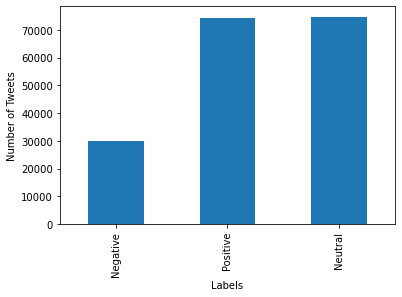

In [16]:
#checking the distribution of the tweets
tweets.Label.value_counts().sort_values().plot(kind = 'bar')
plt.ylabel('Number of Tweets')
plt.xlabel('Labels')

In [17]:
tweets.head()

,text,cleaned_text,tokenized_text,no_stopwords,stemmed_text,Lemmatized_text,sentiment_score,Label
0,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were ...",if i smelled the scent of hand sanitizers today on someone in the past i would think they were s...,"[if, i, smelled, the, scent, of, hand, sanitizers, today, on, someone, in, the, past, i, would, ...","[smelled, scent, hand, sanitizers, today, someone, past, would, think, intoxicated, https, tco, ...","[smell, scent, hand, sanit, today, someon, past, would, think, intox, http, tco, qzvybrogb0]","[smelled, scent, hand, sanitizers, today, someone, past, would, think, intoxicated, http, tco, q...",-0.25,Negative
1,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay thei...,hey and wouldnt it have made more sense to have the players pay their respects to the a https tc...,"[hey, and, wouldnt, it, have, made, more, sense, to, have, the, players, pay, their, respects, t...","[hey, wouldnt, made, sense, players, pay, respects, https, tco, 1qvw0zgypu]","[hey, wouldnt, made, sens, player, pay, respect, http, tco, 1qvw0zgypu]","[hey, wouldnt, made, sense, player, pay, respect, http, tco, 1qvw0zgypu]",0.50,Positive
2,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim ...,trump never once claimed #covid19 was a hoax we all claim that this effort to https tco jkk8vhwhb3,"[trump, never, once, claimed, covid19, was, a, hoax, we, all, claim, that, this, effort, to, htt...","[trump, never, claimed, covid19, hoax, claim, effort, https, tco, jkk8vhwhb3]","[trump, never, claim, covid19, hoax, claim, effort, http, tco, jkk8vhwhb3]","[trump, never, claimed, covid19, hoax, claim, effort, http, tco, jkk8vhwhb3]",0.00,Neutral
3,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that wer...,the one gift #covid19 has give me is an appreciation for the simple things that were always arou...,"[the, one, gift, covid19, has, give, me, is, an, appreciation, for, the, simple, things, that, w...","[one, gift, covid19, give, appreciation, simple, things, always, around, https, tco, z0poalfxcw]","[one, gift, covid19, give, appreci, simpl, thing, alway, around, http, tco, z0poalfxcw]","[one, gift, covid19, give, appreciation, simple, thing, always, around, http, tco, z0poalfxcw]",0.00,Neutral
4,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 \n@kansalrohit69 @DrSyedSehrish @...,25 july media bulletin on novel #coronavirusupdates #covid19 https tco mn0eecsjhh,"[25, july, media, bulletin, on, novel, coronavirusupdates, covid19, https, tco, mn0eecsjhh]","[25, july, media, bulletin, novel, coronavirusupdates, covid19, https, tco, mn0eecsjhh]","[25, juli, media, bulletin, novel, coronavirusupd, covid19, http, tco, mn0eecsjhh]","[25, july, medium, bulletin, novel, coronavirusupdates, covid19, http, tco, mn0eecsjhh]",0.00,Neutral


In [18]:
pos_tweets = tweets[tweets['Label'] == 'Positive']
neg_tweets = tweets[tweets['Label'] == 'Negative']
neut_tweets = tweets[tweets['Label'] == 'Neutral']

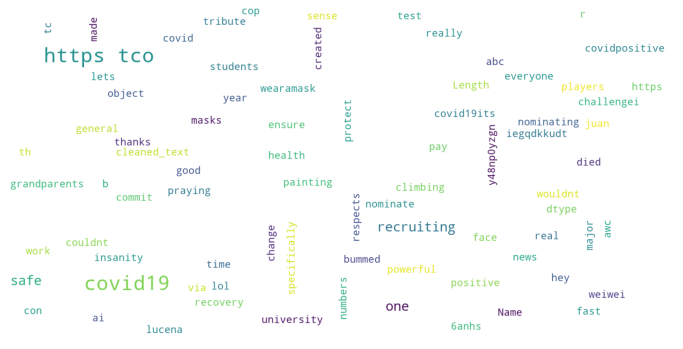

In [19]:
#wordcloud visualization
def plot_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=12, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
plot_wordcloud(pos_tweets['cleaned_text'])


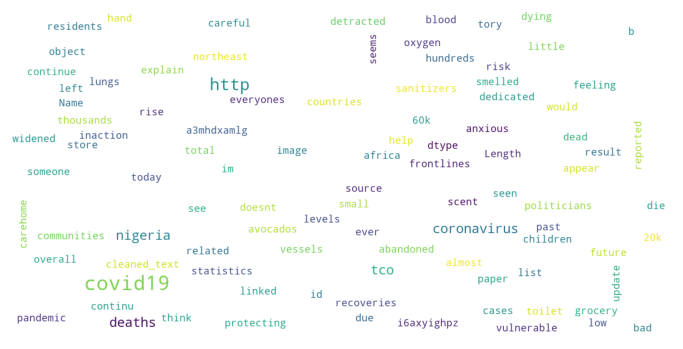

In [20]:
plot_wordcloud(neg_tweets['cleaned_text'])

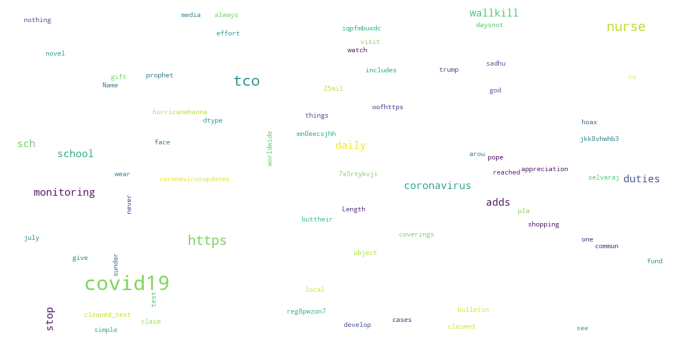

In [21]:
plot_wordcloud(neut_tweets['cleaned_text'])

# IMPLEMENTATION OF MACHINE LEARNING MODELS


In [22]:
ml_data = tweets[['cleaned_text', 'Label', 'stemmed_text', 'Lemmatized_text']]
#creating mappings for the classification
label_mapping = {'Neutral':0, 
                'Positive':1, 
                'Negative':2}
ml_data['Label'] = ml_data['Label'].map(label_mapping)
#shuffling the data
ml_data = ml_data.sample(frac=1)
#creating training and test sets
train_set, test_set = train_test_split(ml_data, test_size=0.3, random_state=101)
train_set.head()

<ipython-input-22-3749ed071b2c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_data['Label'] = ml_data['Label'].map(label_mapping)


,cleaned_text,Label,stemmed_text,Lemmatized_text
27858,im short 200 its very difficult times and tomorrow is my deadline or they take my car and repo i...,2,"[im, short, 200, difficult, time, tomorrow, deadlin, take, car, repo, plz, dona, http, tco, iev6...","[im, short, 200, difficult, time, tomorrow, deadline, take, car, repo, plz, dona, http, tco, iev..."
19995,health update please note the new advice from nsw health when visiting our health facilities#hea...,1,"[health, updat, pleas, note, new, advic, nsw, health, visit, health, facil, health, covid19, htt...","[health, update, please, note, new, advice, nsw, health, visiting, health, facility, health, cov..."
60566,thank lord that you have ushered us into another month of 2020 may you continue to sustain us ev...,0,"[thank, lord, usher, us, anoth, month, 2020, may, continu, sustain, us, even, unusua, http, tco,...","[thank, lord, ushered, u, another, month, 2020, may, continue, sustain, u, even, unusua, http, t..."
140255,facemask for only p25wear a fashionable ethnic vinta facemask #vinta #facemask #protection #coro...,0,"[facemask, p25wear, fashion, ethnic, vinta, facemask, vinta, facemask, protect, coronaviru, http...","[facemask, p25wear, fashionable, ethnic, vinta, facemask, vinta, facemask, protection, coronavir..."
21932,the cases detected last night in #tisnukia district include an employee from issue branch of dc ...,0,"[case, detect, last, night, tisnukia, district, includ, employe, issu, branch, dc, offic, person...","[case, detected, last, night, tisnukia, district, include, employee, issue, branch, dc, office, ..."


In [23]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125375 entries, 27858 to 16584
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   cleaned_text     125375 non-null  object
 1   Label            125375 non-null  int64 
 2   stemmed_text     125375 non-null  object
 3   Lemmatized_text  125375 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.8+ MB


In [24]:
#defining the features and targets
X = train_set['cleaned_text']
y = train_set['Label']
#implementation of text vectorization
count_vectorizer = CountVectorizer(lowercase=False)
tfidf_vectorizer = TfidfVectorizer()
X_cv_transformed = count_vectorizer.fit_transform(X)
X_tf_transformed = tfidf_vectorizer.fit_transform(X)
X_test = test_set['cleaned_text']
X_test_cv_transformed = count_vectorizer.transform(X_test)
X_test_tfidf_transformed = tfidf_vectorizer.transform(X_test)

# Bag of Words Model

In [25]:
#creating the training and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X_cv_transformed, y, test_size=0.25, random_state=42)


In [26]:
#implementing the machine learning models
#NAIVE-BAYES CLASSIFIER
nb = MultinomialNB()
nb.fit(X_train, y_train)
predictions = nb.predict(X_valid)


In [27]:
#evaluating the performance of the model.

print(metrics.classification_report(y_valid, predictions))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86     13123
           1       0.70      0.97      0.81     12913
           2       0.86      0.31      0.45      5308

    accuracy                           0.79     31344
   macro avg       0.82      0.69      0.71     31344
weighted avg       0.82      0.79      0.77     31344



In [28]:
print(metrics.confusion_matrix(y_valid, predictions))

[[10490  2460   173]
 [  263 12552    98]
 [  644  3022  1642]]


In [29]:
#Implementing the Logistic Regression Models
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_valid)

C:\Users\shara\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
#evaluating the performance of the model
print(metrics.classification_report(lr_predictions, y_valid))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     13665
           1       0.95      0.96      0.95     12824
           2       0.85      0.92      0.88      4855

    accuracy                           0.95     31344
   macro avg       0.93      0.94      0.93     31344
weighted avg       0.95      0.95      0.95     31344



In [31]:
#lr confusion matrix
print(metrics.confusion_matrix(lr_predictions, y_valid))

[[12922   355   388]
 [  134 12260   430]
 [   67   298  4490]]


In [32]:
#Random Forest Classifer
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_valid)

In [33]:
print(metrics.classification_report(y_valid, rf_predictions))

              precision    recall  f1-score   support

           0       0.82      0.98      0.90     13123
           1       0.91      0.89      0.90     12913
           2       0.94      0.54      0.68      5308

    accuracy                           0.87     31344
   macro avg       0.89      0.80      0.83     31344
weighted avg       0.88      0.87      0.86     31344



In [34]:
#Decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf_predictions = clf.predict(X_valid)

In [35]:
print(metrics.classification_report(y_valid, clf_predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     13123
           1       0.93      0.94      0.94     12913
           2       0.87      0.84      0.86      5308

    accuracy                           0.94     31344
   macro avg       0.93      0.92      0.93     31344
weighted avg       0.94      0.94      0.94     31344



# TFIDF Model

In [36]:
#creating the training and test sets
X_train_tf, X_valid_tf, y_train, y_valid = train_test_split(X_tf_transformed, y, test_size=0.25, random_state=42)

In [37]:
#multinomial nb
nb_tf = MultinomialNB()
nb_tf.fit(X_train_tf, y_train)
nb_tf_predictions = nb_tf.predict(X_valid_tf)


In [38]:
print(metrics.classification_report(nb_tf_predictions, y_valid))

              precision    recall  f1-score   support

           0       0.71      0.90      0.79     10334
           1       0.98      0.61      0.75     20731
           2       0.05      1.00      0.10       279

    accuracy                           0.71     31344
   macro avg       0.58      0.84      0.55     31344
weighted avg       0.88      0.71      0.76     31344



In [39]:
#logistic regression
log_reg_tf = LogisticRegression()
log_reg_tf.fit(X_train_tf, y_train)
lr_tf_preds = log_reg_tf.predict(X_valid_tf)

C:\Users\shara\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
print(metrics.classification_report(lr_tf_preds, y_valid))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     14709
           1       0.91      0.94      0.93     12570
           2       0.71      0.92      0.80      4065

    accuracy                           0.91     31344
   macro avg       0.87      0.91      0.88     31344
weighted avg       0.92      0.91      0.91     31344



In [41]:
#random forest
rf_tf = RandomForestClassifier()
rf_tf.fit(X_train_tf, y_train)
rf_tf_preds = rf_tf.predict(X_valid_tf)

In [42]:
print(metrics.classification_report(y_valid, rf_tf_preds))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89     13123
           1       0.90      0.89      0.89     12913
           2       0.94      0.52      0.67      5308

    accuracy                           0.86     31344
   macro avg       0.89      0.80      0.82     31344
weighted avg       0.87      0.86      0.86     31344



In [43]:
#decision tree classifier
clf_tf = DecisionTreeClassifier()
clf_tf.fit(X_train_tf, y_train)
clf_tf_preds = clf_tf.predict(X_valid_tf)

In [44]:
print(metrics.classification_report(y_valid, clf_tf_preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     13123
           1       0.93      0.94      0.93     12913
           2       0.86      0.83      0.85      5308

    accuracy                           0.94     31344
   macro avg       0.92      0.92      0.92     31344
weighted avg       0.94      0.94      0.94     31344



In [45]:
#The Bag of Words Model as implemented using the Decision Tree classifier Approach is the best model due to its high precision and recall
#making predictions on the test set
predicted_sentiments = clf.predict(X_test_cv_transformed)
test_set = test_set.drop(columns=['Label'], axis=1)
test_set['Predicted_sentiment'] = predicted_sentiments
label_mapping_pred = {0:'Neutral', 
                1:'Positive', 
                2:'Negative'}
test_set['Predicted_sentiment'] = test_set['Predicted_sentiment'].map(label_mapping_pred)
test_set.head()


,cleaned_text,stemmed_text,Lemmatized_text,Predicted_sentiment
97934,minnesota reports 618 new cases and 3 new deaths bringing total confirmed cases there to 61 516 ...,"[minnesota, report, 618, new, case, 3, new, death, bring, total, confirm, case, 61, 516, 1, 701,...","[minnesota, report, 618, new, case, 3, new, death, bringing, total, confirmed, case, 61, 516, 1,...",Positive
56404,caring for someone with covid19 at home #covid19 watch video https tco 790tbrrnok https tco bxey...,"[care, someon, covid19, home, covid19, watch, video, http, tco, 790tbrrnok, http, tco, bxeyjmlhhf]","[caring, someone, covid19, home, covid19, watch, video, http, tco, 790tbrrnok, http, tco, bxeyjm...",Neutral
13858,everything emily makes is done with a lot of love and passion and it shows i love her hustle its...,"[everyth, emili, make, done, lot, love, passion, show, love, hustl, inspiringem, http, tco, os3v...","[everything, emily, make, done, lot, love, passion, show, love, hustle, inspiringem, http, tco, ...",Positive
66833,tackling the inequality pandemic #covid19 has laid bare risks ignored for decades ie health syst...,"[tackl, inequ, pandem, covid19, laid, bare, risk, ignor, decad, ie, health, system, unabl, http,...","[tackling, inequality, pandemic, covid19, laid, bare, risk, ignored, decade, ie, health, system,...",Negative
172781,its really too bad that didnt trust his instincts ie the media hysteria over #covid19 is the htt...,"[realli, bad, didnt, trust, instinct, ie, media, hysteria, covid19, http, tco, 3gpuv5qxlf]","[really, bad, didnt, trust, instinct, ie, medium, hysteria, covid19, http, tco, 3gpuv5qxlf]",Negative


In [46]:
test_set.to_csv('Covid_prediction_sentiments.csv', index=None)